## 데이터 수집

In [59]:
import matplotlib.pyplot as plt
import matplotlib as mpl # 한글 폰트 설정 (NanumGothic) 
mpl.rcParams['font.family'] = 'NanumGothic'
mpl.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
import seaborn as sns
import pandas as pd
import numpy as np 
import scipy.stats as stats
from sklearn import datasets 
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from copy import deepcopy

In [60]:
import matplotlib.font_manager as fm
# NanumGothic 폰트 경로 추가
font_path = '/usr/share/fonts/truetype/nanum/NanumGothicCoding.ttf'
font_prop = fm.FontProperties(fname=font_path)
mpl.rcParams['font.family'] = font_prop.get_name()


In [2]:
data_df = pd.read_csv('../../datasets/titanic_disaster_train.csv')
data_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 데이터 분석

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- feature continue : Age, Fare
- feature category : Pclass, Sex, SibSp, Parch, Embarked
- label : Survived
- remove 
    + Cabin : 범주형인데 결측 너무 많아서 빼는게 나을 것으로 보임.
    + PassengerId : 유니크 함
    + Name : 유니크 함
    + Ticket : 유니크 함
- missing value : Age, Embarked

In [4]:
data_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [5]:
data_df[['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'Age', 'Fare', 'Survived']].head()

,Pclass,Sex,SibSp,Parch,Embarked,Age,Fare,Survived
0,3,male,1,0,S,22.0,7.2500,0
1,1,female,1,0,C,38.0,71.2833,1
2,3,female,0,0,S,26.0,7.9250,1
3,1,female,1,0,S,35.0,53.1000,1
4,3,male,0,0,S,35.0,8.0500,0


## 데이터 전처리 

### 결측치 처리 - 대표값사용

##### Embarked
- 최대한 다른 변수에 영향을 안주는 범위에서 평균 제일 많은 값 채택 
- 새로 채우는 값이 다른 조건을 찾는 것에 영향 제일 안주도록 최대한 비슷한 패턴에서 평균값 취하기
- 최대한 생존했으며, 동승자 없고, ticket 번호 유사하고, 객실을 부여 받은 사람들
- 모두 S 이므로 S로 채움 

In [6]:
# 우선, Embarked
nan_embarked_records = data_df[data_df['Embarked'].isna()]
nan_embarked_records

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [7]:
data_df[data_df['Name'].str.contains('Stone', na=False)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
319,320,1,1,"Spedden, Mrs. Frederic Oakley (Margaretta Corn...",female,40.0,1,1,16966,134.5,E34,C
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [8]:
data_df[data_df['Cabin'].notna()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S


In [9]:
condition_ticket = "Ticket.str.match('^113\\d{3}$')" # 113572
data_df.query(f"{condition_ticket}")["Ticket"].value_counts()


Ticket
113781    4
113760    4
113803    2
113789    2
113572    2
113806    2
113776    2
113505    2
113798    2
113787    1
113050    1
113807    1
113796    1
113800    1
113804    1
113051    1
113028    1
113773    1
113501    1
113792    1
113503    1
113786    1
113794    1
113783    1
113510    1
113784    1
113043    1
113056    1
113514    1
113767    1
113059    1
113509    1
113788    1
113055    1
Name: count, dtype: int64

In [10]:
# 각 조건들을 변수로 정의
condition_pclass = "Pclass == 1"
condition_fare = "Fare >= 79.0 and Fare <= 82.0"
condition_SibSp = "SibSp == 0"
condition_Parch = "Parch == 0"
condition_Survived = "Survived == 1"
condition_ticket = "Ticket.str.match('^113\\d{3}$')" # 113572

# 모든 조건을 결합하여 쿼리 실행
# data_df[data_df['Cabin'].notna()].query(f"{condition_pclass} and {condition_fare} and {condition_SibSp} and {condition_cabin}")
data_df[data_df['Cabin'].notna()].query(f"{condition_Survived} and {condition_ticket}")
data_df[data_df['Cabin'].notna()].query(f"{condition_Survived} and {condition_ticket} and {condition_SibSp} and {condition_Parch}")


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.55,C103,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.50,A6,S
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.00,B28,NaN
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.50,C104,S
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.00,B28,NaN
857,858,1,1,"Daly, Mr. Peter Denis",male,51.0,0,0,113055,26.55,E17,S


In [11]:
data_df['Embarked'] = data_df['Embarked'].fillna('S')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
# age 는 ML 쓸거니까 다른거 먼저 처리하고 채우자

### 범주형 처리

In [13]:
data_df = data_df.drop(columns=['Cabin', 'PassengerId', 'Ticket', 'Name'])
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


In [14]:
# 일단 제외 하고 가자 
# Survived 는 어차피 labelencode 해야해
# Age는 missing 이후에 처리
final_label_name = 'Survived'
missing_label_name = 'Age'

In [15]:
labelencoder = LabelEncoder()
labelencoder.fit(data_df[final_label_name])
encoded_label = labelencoder.transform(data_df[final_label_name])

In [16]:
# encoded_label 이거 dataframe 만들기 
label_df = pd.DataFrame(data=encoded_label, columns=[final_label_name], index=data_df.index)

In [17]:
missing_label = data_df[missing_label_name]

In [18]:
data_df = data_df.drop(columns=[final_label_name, missing_label_name])
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    891 non-null    int64  
 1   Sex       891 non-null    object 
 2   SibSp     891 non-null    int64  
 3   Parch     891 non-null    int64  
 4   Fare      891 non-null    float64
 5   Embarked  891 non-null    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 41.9+ KB


In [19]:
def split_categorical_numerical(df, unique_threshold=0.05):
    """
    데이터프레임을 범주형과 수치형으로 분리
    
    Parameters:
    - df: 입력 데이터프레임
    - unique_threshold: unique 값 비율 임계값 (기본값 0.05 = 5%)
    
    Returns:
    - categorical_df: 범주형 컬럼만 있는 데이터프레임
    - numerical_df: 수치형 컬럼만 있는 데이터프레임
    """
    
    categorical_cols = []
    numerical_cols = []
    
    n_rows = len(df)
    
    for col in df.columns:
        # unique 값의 비율 계산
        unique_ratio = len(df[col].unique()) / n_rows
        
        # object 타입이거나, unique 값 비율이 임계값보다 작으면 범주형으로 분류
        # df[col].dtype == 'object' or
        if unique_ratio < unique_threshold:
            categorical_cols.append(col)
        else:
            numerical_cols.append(col)
            
    return df[categorical_cols], df[numerical_cols]

In [20]:
cat_df, num_df = split_categorical_numerical(data_df)
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Pclass    891 non-null    int64 
 1   Sex       891 non-null    object
 2   SibSp     891 non-null    int64 
 3   Parch     891 non-null    int64 
 4   Embarked  891 non-null    object
dtypes: int64(3), object(2)
memory usage: 34.9+ KB


In [21]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Fare    891 non-null    float64
dtypes: float64(1)
memory usage: 7.1 KB


In [22]:
def run_onehotencode(data_df, model=OneHotEncoder()):

    columns = data_df.columns
    model_list = []
    for col in columns :
        model.fit(X=data_df[[col]])
        model_list.append(deepcopy(model))
        encoded_pclass = model.transform(X=data_df[[col]]).toarray()
        pclass_name_list = model.get_feature_names_out(input_features=[col])
        pclass_df = pd.DataFrame(data=encoded_pclass, columns=pclass_name_list, index=data_df.index)
        # 원본 자르는거 추가 

        data_df = pd.concat([data_df.drop(columns=[col]), pclass_df], axis=1)

    return data_df, model_list

In [23]:
onehot_df, model_list = run_onehotencode(cat_df)
missing_df = pd.concat([onehot_df, num_df, label_df, missing_label], axis=1)
missing_df.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,...,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S,Fare,Survived,Age
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.2500,0,22.0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,71.2833,1,38.0
2,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.9250,1,26.0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,53.1000,1,35.0
4,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.0500,0,35.0


In [24]:
missing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass_1    891 non-null    float64
 1   Pclass_2    891 non-null    float64
 2   Pclass_3    891 non-null    float64
 3   Sex_female  891 non-null    float64
 4   Sex_male    891 non-null    float64
 5   SibSp_0     891 non-null    float64
 6   SibSp_1     891 non-null    float64
 7   SibSp_2     891 non-null    float64
 8   SibSp_3     891 non-null    float64
 9   SibSp_4     891 non-null    float64
 10  SibSp_5     891 non-null    float64
 11  SibSp_8     891 non-null    float64
 12  Parch_0     891 non-null    float64
 13  Parch_1     891 non-null    float64
 14  Parch_2     891 non-null    float64
 15  Parch_3     891 non-null    float64
 16  Parch_4     891 non-null    float64
 17  Parch_5     891 non-null    float64
 18  Parch_6     891 non-null    float64
 19  Embarked_C  891 non-null    f

### 결측치 처리 - ML

##### ML로 결측치 채우기
- 기존에 randomforest가 좋았으니 그거 씀.
- 사전에 준비 해둔 값들을 사용해서 채우기

##### 결측치 결과 
- r2 score : 0.7
- 평균 오차 : 5.46
- 나쁘지 않은 성능으로 보임.

In [25]:
def train_model(df, target_column, model=RandomForestRegressor()):
    """
    주어진 데이터프레임과 타겟 컬럼, 모델로 학습을 수행하고 평가 지표를 반환하는 함수
    
    Parameters:
    df : DataFrame - 학습에 사용할 데이터프레임
    target_column : str - 예측하고자 하는 타겟 컬럼명
    model : sklearn model object - 학습에 사용할 모델 (기본값: RandomForestRegressor)
    
    Returns:
    dict - 모델 성능 평가 결과
    """
    
    # 특성과 타겟 분리
    X = df.drop(columns=[target_column])
    y = df[target_column]
    
    # 모델 학습
    model.fit(X, y)
    
    # 예측
    predictions = model.predict(X)
    
    # 평가 지표 계산
    results = {
        'model_name': model.__class__.__name__,
        'r2_score': r2_score(y_true=y, y_pred=predictions),
        'mse': mean_squared_error(y_true=y, y_pred=predictions),
        'model_score': model.score(X, y)
    }
    
    return results, model

In [26]:
def evaluate_predictions(df, target_column, trained_model):
    """
    학습된 모델을 사용하여 예측을 수행하고 결과를 평가하는 함수
    
    Parameters:
    df : DataFrame - 예측에 사용할 데이터프레임
    target_column : str - 예측하고자 하는 타겟 컬럼명
    trained_model : sklearn model - 학습된 모델
    
    Returns:
    DataFrame - 실제값과 예측값을 포함한 데이터프레임
    """
    # 타겟 컬럼의 실제값이 있는 데이터만 선택 (검증용)
    test_df = df[df[target_column].notna()].copy()
      
    # 예측을 위한 특성 준비
    X_test = test_df.drop(columns=[target_column])
    
    # 예측 수행
    predictions = trained_model.predict(X_test)
    
    # 결과 비교 데이터프레임 생성
    comparison = pd.DataFrame({
        'actual': test_df[target_column],
        'predicted': predictions,
        'difference': test_df[target_column] - predictions
    })
    
    return comparison

In [27]:
rf_results, rf_model = train_model(missing_df.dropna(), missing_label_name, RandomForestRegressor())

In [28]:
rf_results

{'model_name': 'RandomForestRegressor',
 'r2_score': 0.7322272186473586,
 'mse': 56.42603904722433,
 'model_score': 0.7322272186473586}

In [47]:
comparison = evaluate_predictions(missing_df.dropna(), missing_label_name, rf_model)
comparison.head(), comparison['difference'].abs().mean(), comparison['difference'].mean()

(   actual  predicted  difference
 0    22.0  22.971909   -0.971909
 1    38.0  42.006667   -4.006667
 2    26.0  26.977286   -0.977286
 3    35.0  33.876571    1.123429
 4    35.0  31.523122    3.476878,
 5.469913576676909,
 -0.06956845709114431)

In [30]:
def fill_missing_values(df, target_column, trained_model):
    """
    학습된 모델을 사용하여 결측치를 예측하고 채우는 함수
    
    Parameters:
    df : DataFrame - 결측치를 채울 데이터프레임
    target_column : str - 결측치를 채울 타겟 컬럼명
    trained_model : sklearn model - 학습된 모델
    
    Returns:
    DataFrame - 결측치가 채워진 데이터프레임
    """
    # 원본 데이터 복사
    filled_df = df.copy()
    
    # 결측치가 있는 레코드 선택
    missing_mask = df[target_column].isna()
    missing_records = df[missing_mask]
    
    if len(missing_records) > 0:
        # 예측을 위한 특성 준비 (target_column 제외)
        X_missing = missing_records.drop(columns=[target_column])
        
        # 결측치 예측
        predictions = trained_model.predict(X_missing)
        
        # 예측값으로 결측치 채우기
        filled_df.loc[missing_mask, target_column] = predictions
    
    return filled_df

In [31]:
# NaN인 레코드의 인덱스 저장
nan_indices = missing_df[missing_df[missing_label_name].isna()].index

# 결측치 채우기
filled_missing_df = fill_missing_values(missing_df, missing_label_name, rf_model)

# nan_indices에 해당하는 예측값들을 정수로 변환
filled_missing_df.loc[nan_indices, missing_label_name] = filled_missing_df.loc[nan_indices, missing_label_name].astype(float).round(0).astype(int)

In [32]:
filled_missing_df.loc[nan_indices, missing_label_name]

5      34.0
17     35.0
19     15.0
26     35.0
28     19.0
       ... 
859    26.0
863    23.0
868    25.0
878    27.0
888    26.0
Name: Age, Length: 177, dtype: float64

In [33]:
filled_missing_df = filled_missing_df.drop(columns=[final_label_name])

In [34]:
filled_missing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass_1    891 non-null    float64
 1   Pclass_2    891 non-null    float64
 2   Pclass_3    891 non-null    float64
 3   Sex_female  891 non-null    float64
 4   Sex_male    891 non-null    float64
 5   SibSp_0     891 non-null    float64
 6   SibSp_1     891 non-null    float64
 7   SibSp_2     891 non-null    float64
 8   SibSp_3     891 non-null    float64
 9   SibSp_4     891 non-null    float64
 10  SibSp_5     891 non-null    float64
 11  SibSp_8     891 non-null    float64
 12  Parch_0     891 non-null    float64
 13  Parch_1     891 non-null    float64
 14  Parch_2     891 non-null    float64
 15  Parch_3     891 non-null    float64
 16  Parch_4     891 non-null    float64
 17  Parch_5     891 non-null    float64
 18  Parch_6     891 non-null    float64
 19  Embarked_C  891 non-null    f

### 이상치 처리
- Fare는 가격 차가 의미가 있을 것이라고 생각
- Age는 특정 나이 이상이면 크게 의미 없을 것이라고 생각, 다만 ML로 채운값이라 당장 조절하지는 않음.

findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

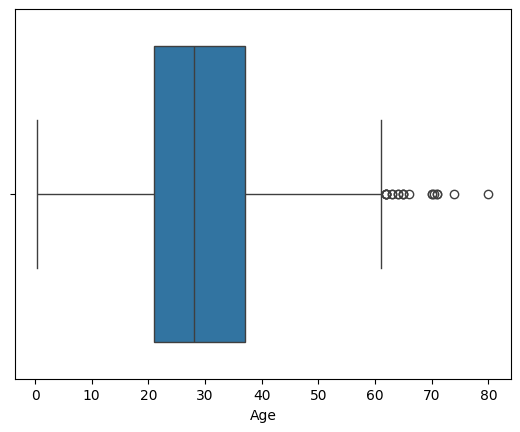

findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

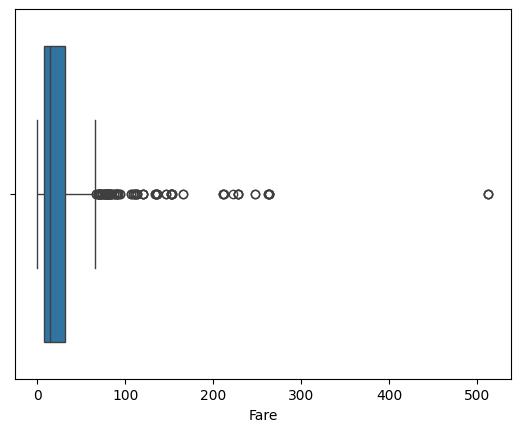

In [63]:
sns.boxplot(data=filled_missing_df, x='Age')
plt.show()
sns.boxplot(data=filled_missing_df, x='Fare')
plt.show()

### 스케일링


In [35]:
# 일단 통짜로 돌려보고 데이터 특성에 따라 따로 돌리는 거를 고려해 보아야 할 듯?
standardscaler = StandardScaler()
standardscaler.fit(filled_missing_df)

StandardScaler()

In [36]:
# 스케일링 적용
scailing_array = standardscaler.transform(filled_missing_df)
# 스케일링된 데이터를 DataFrame으로 변환
scailing_df = pd.DataFrame(scailing_array, columns=filled_missing_df.columns)
scailing_df.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp_0,SibSp_1,SibSp_2,SibSp_3,SibSp_4,...,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6,Embarked_C,Embarked_Q,Embarked_S,Fare,Age
0,-0.565685,-0.510152,0.902587,-0.737695,0.737695,-1.465746,1.806421,-0.180125,-0.135225,-0.143592,...,-0.314076,-0.075122,-0.067153,-0.075122,-0.03352,-0.482043,-0.307562,0.615838,-0.502445,-0.559667
1,1.767767,-0.510152,-1.107926,1.355574,-1.355574,-1.465746,1.806421,-0.180125,-0.135225,-0.143592,...,-0.314076,-0.075122,-0.067153,-0.075122,-0.03352,2.074505,-0.307562,-1.623803,0.786845,0.602013
2,-0.565685,-0.510152,0.902587,1.355574,-1.355574,0.682247,-0.553581,-0.180125,-0.135225,-0.143592,...,-0.314076,-0.075122,-0.067153,-0.075122,-0.03352,-0.482043,-0.307562,0.615838,-0.488854,-0.269247
3,1.767767,-0.510152,-1.107926,1.355574,-1.355574,-1.465746,1.806421,-0.180125,-0.135225,-0.143592,...,-0.314076,-0.075122,-0.067153,-0.075122,-0.03352,-0.482043,-0.307562,0.615838,0.420730,0.384198
4,-0.565685,-0.510152,0.902587,-0.737695,0.737695,0.682247,-0.553581,-0.180125,-0.135225,-0.143592,...,-0.314076,-0.075122,-0.067153,-0.075122,-0.03352,-0.482043,-0.307562,0.615838,-0.486337,0.384198


findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

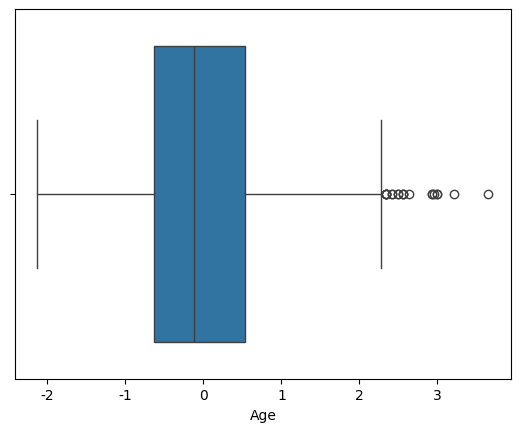

findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not found.
findfont: Font family 'NanumGothicCoding' not 

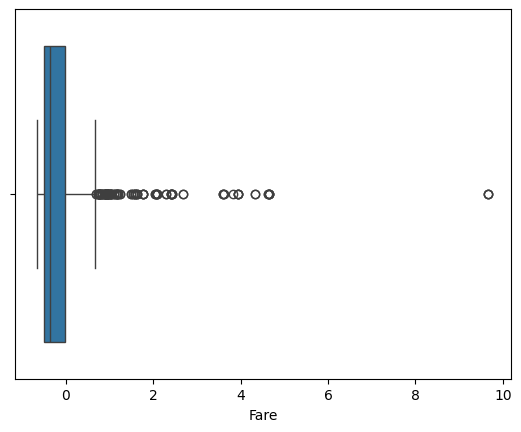

In [64]:
sns.boxplot(data=scailing_df, x='Age')
plt.show()
sns.boxplot(data=scailing_df, x='Fare')
plt.show()

## 데이터 분할

In [37]:
train_list = []
test_list = []
test_size = 0.2
istrain = True
for num in range(100):
      train_features, test_features, train_label, test_label =\
            train_test_split(scailing_df, encoded_label, test_size=test_size, random_state=num)
      train_features.shape, test_features.shape, train_label.shape, test_label.shape
      logisticregression = LogisticRegression()
      logisticregression.fit(X=train_features, y=train_label)
      predict_train = logisticregression.predict(X=train_features)
      train_list.append(accuracy_score(y_true=train_label, y_pred=predict_train))
      predict_test = logisticregression.predict(X=test_features)
      test_list.append(accuracy_score(y_true=test_label, y_pred=predict_test))
istrain = False

In [38]:
max_value = max(test_list)
max_index = test_list.index(max_value)
print(max_value, max_index)

0.8715083798882681 18


In [39]:
train_list[max_index]

0.797752808988764

In [40]:
if istrain :
      train_features, test_features, train_label, test_label =\
            train_test_split(scailing_df, encoded_label, test_size=test_size, random_state=max_index)
      train_features.shape, test_features.shape, train_label.shape, test_label.shape

## 모델 학습 

In [41]:
if istrain :
    logisticregression = LogisticRegression()
    logisticregression.fit(X=train_features, y=train_label)

## 모델 평가 

##### 평가
- train accuracy_score : 0.87
- test accuracy_score : 0.79
- 나쁘지 않은 성능 으로 판단

In [42]:
if istrain :
    predict_train = logisticregression.predict(X=train_features)
    accuracy_score(y_true=train_label, y_pred=predict_train)

In [43]:
if istrain :
    predict_test = logisticregression.predict(X=test_features)
    accuracy_score(y_true=test_label, y_pred=predict_test)

## 모델 배포

### 세이브할 모델들
- onehotencode 모델 : 사용자 입력 받은 category 데이터 변환
- sampling 모델 : 사용자 입력 받은 continue 데이터 변환 (onehotencode 결과 포함)
- predict 모델 : 변환한 데이터 입력으로 label 예측값 리턴
- labelencode 모델 : 리턴받은 데이터를 기대하는 형태로 변환 후 리턴 (encode 자체를 로드 할 필요보다는 매핑 순서만 받아도 될 듯?)

In [45]:
import pickle

# 모든 모델 정보를 저장할 딕셔너리 생성
model_info = {
    'onehotencoders': model_list,  # 카테고리형 변수들의 원핫인코더 모델들
    'standardscaler': standardscaler,  # 스케일링 모델
    'logisticregression': logisticregression,  # 예측 모델
    'labelencoder': labelencoder
}

# 파일 경로 설정
save_file_name = '../../models/titanic_disaster.pkl'

# 모든 모델 정보를 함께 저장
with open(save_file_name, 'wb') as save_file:
    pickle.dump(model_info, save_file)

print("모든 모델 정보가 저장되었습니다.")

모든 모델 정보가 저장되었습니다.
